# Train And Test - CIRFAR-10 Image Classification XPU

- Imports
  - standard libs
  - 3rd party libs
  - alpabetical or logical grouping
- Set random seed
- Config and Hyperparams
- Dataset and Dataloader
- Model definition/class
- Helper functions (training, eval, visualization)
- Then main code
- Extras
  - We will need torchvision and use torchvision.datasets to load CIRFAR-10
  - CIFAR-10 is a 10 class image dataset, pretty small in size and good for lab/
  testing/learning
    - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

2025-01-21 21:20:30,912 - root - INFO - Seed set to: 327529164
2025-01-21 21:20:30,937 - root - INFO - Using device: cuda


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:03<00:00, 49.5MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/25], Loss: 1.2664
Epoch [2/25], Loss: 0.9002
Epoch [3/25], Loss: 0.7417
Epoch [4/25], Loss: 0.6086
Epoch [5/25], Loss: 0.4989
Epoch [6/25], Loss: 0.3949
Epoch [7/25], Loss: 0.3128
Epoch [8/25], Loss: 0.2378
Epoch [9/25], Loss: 0.1855
Epoch [10/25], Loss: 0.1523
Epoch [11/25], Loss: 0.1206
Epoch [12/25], Loss: 0.1090
Epoch [13/25], Loss: 0.0938
Epoch [14/25], Loss: 0.0905
Epoch [15/25], Loss: 0.0790
Epoch [16/25], Loss: 0.0799
Epoch [17/25], Loss: 0.0803
Epoch [18/25], Loss: 0.0652
Epoch [19/25], Loss: 0.0721
Epoch [20/25], Loss: 0.0638
Epoch [21/25], Loss: 0.0697
Epoch [22/25], Loss: 0.0602
Epoch [23/25], Loss: 0.0631
Epoch [24/25], Loss: 0.0614
Epoch [25/25], Loss: 0.0547


2025-01-21 21:24:41,833 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-01-21 21:24:41,835 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-01-21 21:24:41,837 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-01-21 21:24:41,837 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\phill\\miniconda3\\envs\\cuda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-01-21 21:24:41,837 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\phill\\miniconda3\\envs\\cuda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='

Accuracy on the test set: 69.94%


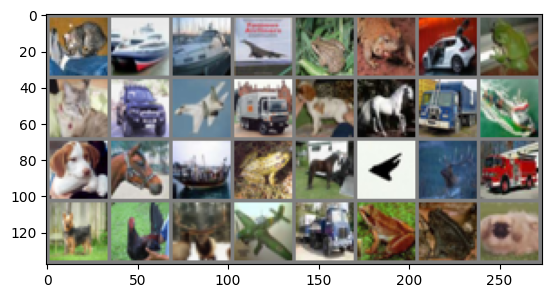

GroundTruth: cat ship ship airplane
Predicted: cat automobile ship ship
Model saved as cnn_cifar10.pth


In [1]:
import torch
import torch.nn as nn
from torch.amp import GradScaler, autocast
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import logging

hp = {
    "batch_size": 32,
    "epochs": 25,
    "random_seed": 42,
    "randomize_seed": True,
    "cpu_only": False,
    "device": "cpu",
}

# Logging configuration
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Randomize seed if set to True
if hp['randomize_seed']:
    hp['random_seed'] = random.randint(0, 1000000000)
logging.info(f"Seed set to: {hp['random_seed']}")  

# Simple CNN Class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Device configuration
def get_device():
    """
    This will check for an Intel XPU device and return it if available, otherwise it will return cpu.

    Returns the torch device to use.
    """
    if hp['cpu_only'] == False:
        #device = "xpu" if torch.xpu.is_available() else "cpu"
        if torch.xpu.is_available():
            device = "xpu"
        elif torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"

        logging.info(f"Using device: {device}")
        return device
    else:
        logging.info("Using CPU only")
        return "cpu"

def train_model(epochs, model, train_loader, device, optimizer, criterion, scaler=None):
    # 5. Training the Model
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            if device != "cpu":
                with torch.amp.autocast(device):
                    # Forward pass
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
            else:
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{hp["epochs"]}], Loss: {running_loss/len(train_loader):.4f}')

# 7. Visualizing Some Predictions
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Main function
def main():

    # 1 Set the device
    hp["device"] = get_device()

    # 2 Dataset, Dataloader, Transform
    # The transform using (0.5, 0.5, 0.5) is used to normalize the image data
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Download and load the training data
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
    # Download and load the test data
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    # Create the dataloader for training and testing data
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=hp['batch_size'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                             batch_size=hp['batch_size'], shuffle=False)
    # 3 SimpleCNN Class
    model_0 = SimpleCNN().to(hp["device"])
    
    # 4 Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_0.parameters(), lr=0.001)


    if hp['cpu_only'] == False:
        scaler = torch.amp.GradScaler(hp["device"])
        train_model(hp["epochs"], model_0, train_loader, hp["device"], optimizer, criterion, scaler=scaler)
    else:
        train_model(hp["epochs"], model_0, train_loader, hp["device"], optimizer, criterion)

    # 6. Evaluating the Model
    model_0.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(hp["device"]), labels.to(hp["device"])
            outputs = model_0(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

    # Get random test images and predictions
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(hp["device"]), labels.to(hp["device"])

    # Display images
    imshow(torchvision.utils.make_grid(images.cpu()))
    print('GroundTruth:', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))

    # Predict and display results
    outputs = model_0(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted:', ' '.join(f'{train_dataset.classes[predicted[j]]}' for j in range(4)))

    # 8. Saving the Model
    torch.save(model_0.state_dict(), 'cnn_cifar10.pth')
    print("Model saved as cnn_cifar10.pth")

# Run the main function
if __name__ == '__main__':
    main()
